In [1]:
import warnings
import numpy as np
import pandas as pd

# settings
pd.set_option('mode.chained_assignment', None)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# statistics
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from linearmodels.panel import PooledOLS, RandomEffects

# imbalance
from imblearn.under_sampling import RandomUnderSampler

# visualization
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# data preprocessing and models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# machine learning
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv("C:/Users/Настя/YandexDisk-n4skolesnikova/HSE 4th year/Graduation Thesis/data/PANEL_DATA.csv")
df = df.drop('Unnamed: 0', axis=1)
print(df.shape)
df.head()

(2694303, 23)


,REGION,region_road,YEAR_MONTH,n_ACCIDENTS,MONTH,SEASON,YEAR,COVID_YEARS,HOLIDAYS,avg_ACC_in_REG_prev_year,...,n_pedestrian_violation_ACC_3m,n_impaired_driving_ACC_3m,n_maneuver_violation_ACC_3m,n_traffic_control_violation_ACC_3m,n_license_violation_ACC_3m,n_crossing_violation_ACC_3m,n_is_WEEKEND_ACC_3m,n_is_NIGHT_ACC_3m,n_is_PEAK_HOUR_ACC_3m,is_toll
0,10011,10011_11173,2016-01,0,1,1,2016,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10011,10011_11173,2016-02,0,2,1,2016,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10011,10011_11173,2016-03,0,3,2,2016,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10011,10011_11173,2016-04,0,4,2,2016,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10011,10011_11173,2016-05,0,5,2,2016,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.columns

Index(['REGION', 'region_road', 'YEAR_MONTH', 'n_ACCIDENTS', 'MONTH', 'SEASON',
       'YEAR', 'COVID_YEARS', 'HOLIDAYS', 'avg_ACC_in_REG_prev_year',
       'avg_ACC_3m', 'n_ACC_prev_m', 'n_wrong_way_ACC_3m',
       'n_pedestrian_violation_ACC_3m', 'n_impaired_driving_ACC_3m',
       'n_maneuver_violation_ACC_3m', 'n_traffic_control_violation_ACC_3m',
       'n_license_violation_ACC_3m', 'n_crossing_violation_ACC_3m',
       'n_is_WEEKEND_ACC_3m', 'n_is_NIGHT_ACC_3m', 'n_is_PEAK_HOUR_ACC_3m',
       'is_toll'],
      dtype='object')

In [4]:
print(f"Final check for the gaps: {df.isna().any().sum()} gaps")

Final check for the gaps: 0 gaps


In [5]:
df_hypoth = df.copy()

### Hypothesis 1.1: 
#### «The average number of traffic accidents per month on toll roads is lower than on alternative free roads»


### Hypothesis 1.2: 
#### «The factors influencing the number of traffic accidents differ for toll and free roads»

----

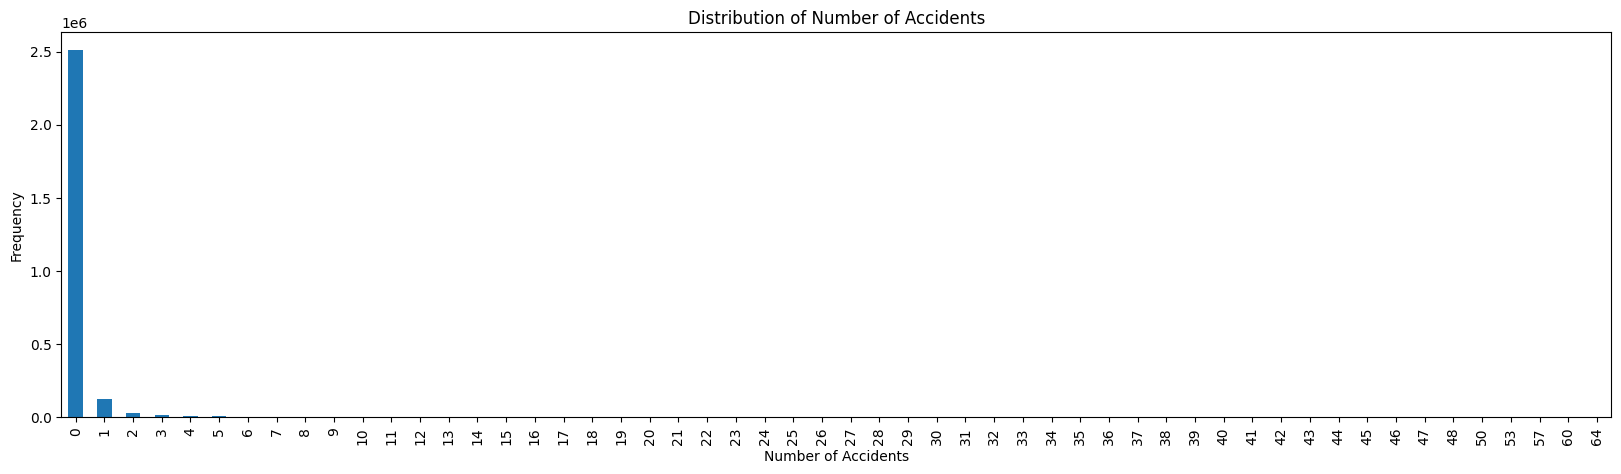

In [6]:
plt.figure(figsize=(20, 5))
df_hypoth['n_ACCIDENTS'].value_counts().sort_index().plot(kind='bar')

plt.title('Distribution of Number of Accidents')
plt.xlabel('Number of Accidents')
plt.ylabel('Frequency')
plt.xticks(rotation=90)

plt.show()

# Econometrics

## Analysis of features

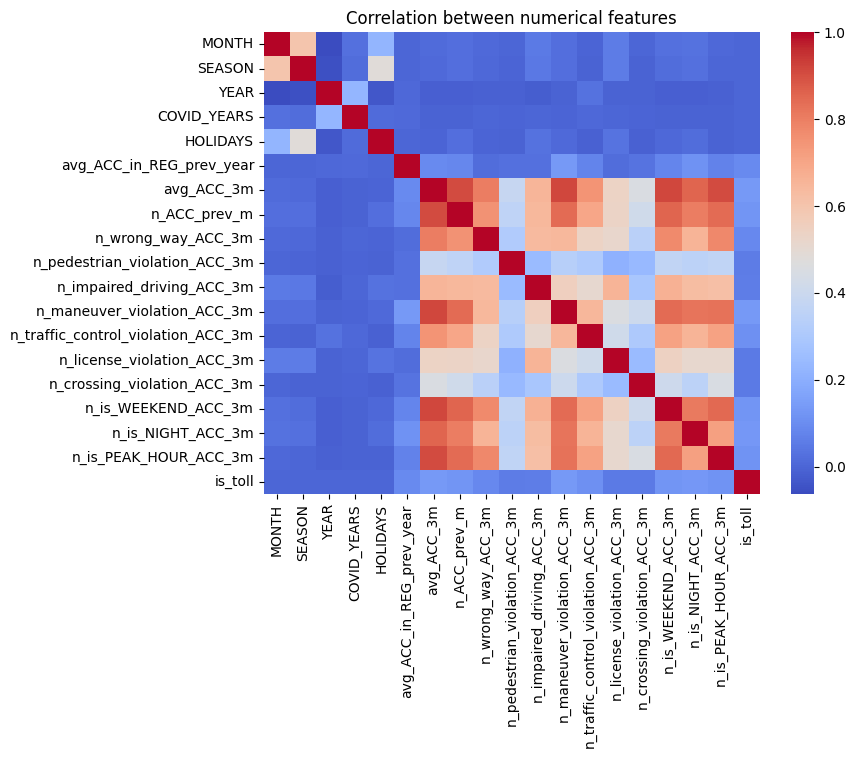

In [7]:
meaningful_df = df_hypoth.drop(['REGION', 'n_ACCIDENTS'], axis=1)
corr_matrix = meaningful_df.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between numerical features")
plt.show()

In [8]:
upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
corr_pairs = corr_matrix.where(upper)

high_corr = corr_pairs.stack().reset_index()
high_corr.columns = ['Feature1', 'Feature2', 'Correlation']

high_corr = high_corr[high_corr['Correlation'].abs() > 0.9]
high_corr = high_corr.reindex(high_corr['Correlation'].abs().sort_values(ascending=False).index)
# print(high_corr)

for f1, f2, f3 in high_corr[['Feature1', 'Feature2', 'Correlation']].values:
    print(f"{f1} — {f2}: | {f3}")

avg_ACC_3m — n_is_WEEKEND_ACC_3m: | 0.915345382337045
avg_ACC_3m — n_maneuver_violation_ACC_3m: | 0.9132981306347564
avg_ACC_3m — n_ACC_prev_m: | 0.907884847423517
avg_ACC_3m — n_is_PEAK_HOUR_ACC_3m: | 0.9062626774982653


In [9]:
meaningful_df = df_hypoth.drop(['REGION', 'n_ACCIDENTS'], axis=1)
meaningful_df = meaningful_df.select_dtypes(include=['int64', 'float64'])

vif = pd.DataFrame()
vif["feature"] = meaningful_df.columns
vif["VIF"] = [variance_inflation_factor(meaningful_df.values, i) for i in range(meaningful_df.shape[1])]

C:\Users\Настя\AppData\Local\Temp\ipykernel_26872\3921723422.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


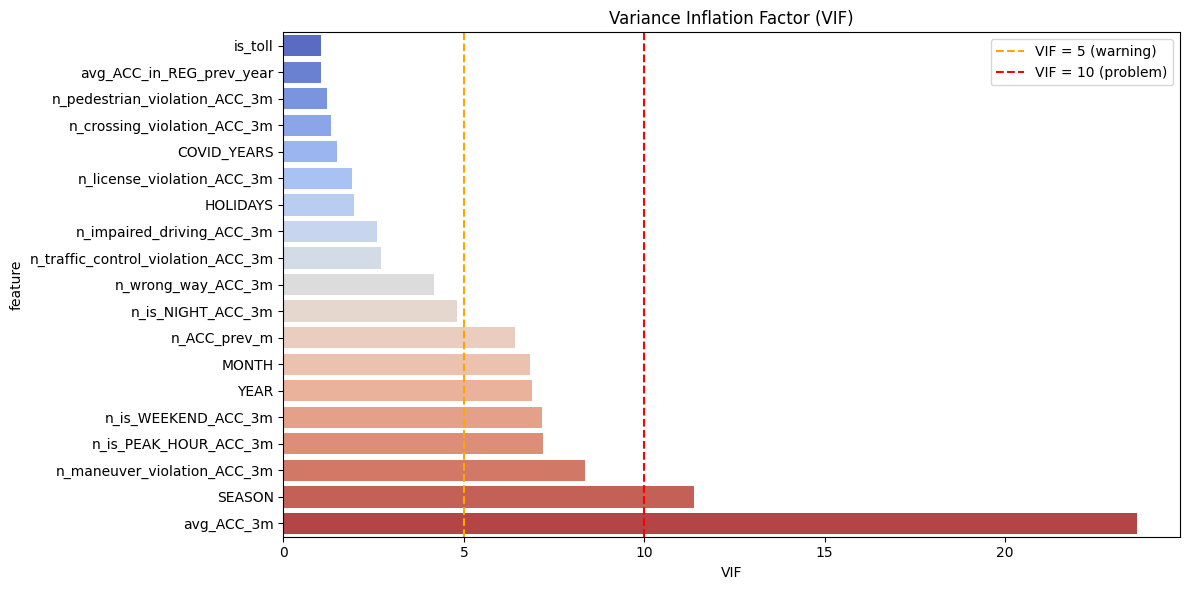

In [10]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=vif.sort_values(by="VIF", ascending=True),
    x="VIF",
    y="feature",
    palette="coolwarm"
)
plt.axvline(5, color='orange', linestyle='--', label='VIF = 5 (warning)')
plt.axvline(10, color='red', linestyle='--', label='VIF = 10 (problem)')
plt.title("Variance Inflation Factor (VIF)")
plt.xlabel("VIF")
plt.ylabel("feature")
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# high_vif_features = vif[vif["VIF"] > 10]['feature'].to_list()
# df_hypoth.drop(columns=high_vif_features, axis=1, inplace=True)

print(f"Num of features before the analysis: {df.shape[1]}")
print(f"Num of features after: {df_hypoth.shape[1]}")

Num of features before the analysis: 23
Num of features after: 23


To conduct a thorough and interpretable analysis, we did not rely solely on correlation values or VIF as the only criteria for removing variables. Instead, we considered them in combination with the conceptual meaning of the features, eliminating those that duplicated each other in essence. In the subsequent analysis, we will refer to both the diagnostic values and this reasoning when interpreting the results of hypothesis testing.

## Pooled Ordinary Least Squares

Hypothesis 1.1, or «the average number of traffic accidents per month on toll roads is lower than on alternative free roads», can be tested using several specifications of a panel regression model with fixed effects, progressively increasing the complexity of the model and checking the robustness of the results.

**1. Baseline Model (`n_ACCIDENTS ~ is_toll`)**
The initial specification includes only the variable `is_toll` to assess its direct impact on the number of accidents without accounting for other factors. This simple model captures the "raw" difference between toll and free roads. Although potentially biased due to omitted variables, it serves as an important starting point for hypothesis testing.

**2. Model with Time Characteristics (`+ SEASON + MONTH + is_NIGHT + YEAR + HOLIDAYS + ...`)**
The second specification adds time-related predictors: season, weekday, weekend/working day, time of day, and rush hour. These variables help account for seasonal and behavioral patterns in accident rates linked to the calendar and traffic routines. Controlling for these factors helps isolate the effect of `is_toll` from cyclical influences.

**3. Full Model (all control variables)**
The fifth model combines all of the above predictor blocks and represents the most comprehensive specification. It allows for an assessment of the robustness of the `is_toll` effect while simultaneously controlling for temporal, behavioral, and infrastructural factors. If `is_toll` remains significant in this model, it indicates an independent influence of toll status on accident rates and supports the hypothesis that toll and free roads differ in terms of safety.

In [12]:
toll_roads_percent = ((df_hypoth['is_toll'] == 1).sum() / df_hypoth.shape[0]) * 100
print(f"Percent of obs on toll roads (with negative sampling): {round(toll_roads_percent, 2)}%\n")

df_accidents = df_hypoth[df_hypoth['n_ACCIDENTS'] > 0]
toll_accidents_percent = ((df_accidents['is_toll'] == 1).sum() / df_accidents.shape[0]) * 100
print(f"Percent of accidents on toll roads (without negative sampling): {round(toll_accidents_percent, 2)}%")

Percent of obs on toll roads (with negative sampling): 0.63%

Percent of accidents on toll roads (without negative sampling): 2.12%


Due to the imbalance we'll test the hypothesis two ways:

0. Without balancing
1. UnderSampling
2. Sample Weights

### (0). Without balancing

In [13]:
df_hypoth_copy = df_hypoth.copy()

# preparing dataset
# df_hypoth_copy['region_road'] = df_hypoth_copy['REGION'].astype(str) + "_" + df_hypoth_copy['road_name'].astype(str)
df_hypoth_copy['YEAR_MONTH'] = pd.to_datetime(df_hypoth_copy['YEAR_MONTH'])
df_hypoth_copy = df_hypoth_copy.set_index(['region_road', 'YEAR_MONTH'])

In [14]:
X1 = sm.add_constant(df_hypoth_copy[['is_toll']])
y = df_hypoth_copy['n_ACCIDENTS']

model1 = PooledOLS(y, X1)
res1 = model1.fit(cov_type='robust')

print('\n1. Base model:')
print(res1.summary)


1. Base model:
                          PooledOLS Estimation Summary                          
Dep. Variable:            n_ACCIDENTS   R-squared:                        0.0151
Estimator:                  PooledOLS   R-squared (Between):              0.0243
No. Observations:             2694303   R-squared (Within):               0.0000
Date:                Thu, May 08 2025   R-squared (Overall):              0.0151
Time:                        02:50:32   Log-likelihood                -3.531e+06
Cov. Estimator:                Robust                                           
                                        F-statistic:                   4.118e+04
Entities:                       24273   P-value                           0.0000
Avg Obs:                       111.00   Distribution:               F(1,2694301)
Min Obs:                       111.00                                           
Max Obs:                       111.00   F-statistic (robust):             1651.3
            

In [15]:
X2 = sm.add_constant(df_hypoth_copy[['is_toll', 'SEASON', 'MONTH', 'YEAR', 'COVID_YEARS', 'HOLIDAYS', 'n_is_WEEKEND_ACC_3m', 'n_is_NIGHT_ACC_3m', 'n_is_PEAK_HOUR_ACC_3m']])
y = df_hypoth_copy['n_ACCIDENTS']

model2 = PooledOLS(y, X2)
res2 = model2.fit(cov_type='robust')

print('\n2. Time specification:')
print(res2.summary)


2. Time specification:
                          PooledOLS Estimation Summary                          
Dep. Variable:            n_ACCIDENTS   R-squared:                        0.6592
Estimator:                  PooledOLS   R-squared (Between):              0.9768
No. Observations:             2694303   R-squared (Within):               0.1404
Date:                Thu, May 08 2025   R-squared (Overall):              0.6592
Time:                        02:50:41   Log-likelihood                -2.101e+06
Cov. Estimator:                Robust                                           
                                        F-statistic:                   5.791e+05
Entities:                       24273   P-value                           0.0000
Avg Obs:                       111.00   Distribution:               F(9,2694293)
Min Obs:                       111.00                                           
Max Obs:                       111.00   F-statistic (robust):             6013.6
    

In [50]:
meaningful_df = df_hypoth.drop(['REGION', 'n_ACCIDENTS'], axis=1)
meaningful_df = meaningful_df.select_dtypes(include=['int64', 'float64'])
X3_cols = meaningful_df.columns.to_list()

In [17]:
X3 = sm.add_constant(df_hypoth_copy[X3_cols])

y = df_hypoth_copy['n_ACCIDENTS']

model5 = PooledOLS(y, X3)
res5 = model5.fit(cov_type='robust')

print('\n3. Full model:')
print(res5.summary)


3. Full model:
                          PooledOLS Estimation Summary                          
Dep. Variable:            n_ACCIDENTS   R-squared:                        0.6955
Estimator:                  PooledOLS   R-squared (Between):              0.9861
No. Observations:             2694303   R-squared (Within):               0.2208
Date:                Thu, May 08 2025   R-squared (Overall):              0.6955
Time:                        02:50:57   Log-likelihood                -1.949e+06
Cov. Estimator:                Robust                                           
                                        F-statistic:                    3.24e+05
Entities:                       24273   P-value                           0.0000
Avg Obs:                       111.00   Distribution:              F(19,2694283)
Min Obs:                       111.00                                           
Max Obs:                       111.00   F-statistic (robust):             3807.5
            

### (1). Undersampling

In [18]:
X = df_hypoth_copy.drop(columns=["is_toll"])
y = df_hypoth_copy["is_toll"]

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

df_balanced = pd.concat([X_resampled, y_resampled], axis=1)

In [19]:
X1 = sm.add_constant(df_balanced[['is_toll']])
y = df_balanced['n_ACCIDENTS']

model1 = PooledOLS(y, X1)
res1 = model1.fit(cov_type='robust')

print('\n1. Base model (undersampling):')
print(res1.summary)


1. Base model (undersampling):
                          PooledOLS Estimation Summary                          
Dep. Variable:            n_ACCIDENTS   R-squared:                        0.0455
Estimator:                  PooledOLS   R-squared (Between):              0.0353
No. Observations:               33744   R-squared (Within):               0.0000
Date:                Thu, May 08 2025   R-squared (Overall):              0.0455
Time:                        02:50:59   Log-likelihood                -8.733e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      1608.7
Entities:                       12338   P-value                           0.0000
Avg Obs:                       2.7350   Distribution:                 F(1,33742)
Min Obs:                       1.0000                                           
Max Obs:                       111.00   F-statistic (robust):             160

In [20]:
X2 = sm.add_constant(df_balanced[['is_toll', 'SEASON', 'MONTH', 'YEAR', 'COVID_YEARS', 'HOLIDAYS', 'n_is_WEEKEND_ACC_3m', 'n_is_NIGHT_ACC_3m', 'n_is_PEAK_HOUR_ACC_3m']])
y = df_balanced['n_ACCIDENTS']

model2 = PooledOLS(y, X2)
res2 = model2.fit(cov_type='robust')

print('\n2. Time specification (undersampling):')
print(res2.summary)


2. Time specification (undersampling):
                          PooledOLS Estimation Summary                          
Dep. Variable:            n_ACCIDENTS   R-squared:                        0.7888
Estimator:                  PooledOLS   R-squared (Between):              0.6908
No. Observations:               33744   R-squared (Within):               0.2524
Date:                Thu, May 08 2025   R-squared (Overall):              0.7888
Time:                        02:50:59   Log-likelihood                -6.188e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                     1.4e+04
Entities:                       12338   P-value                           0.0000
Avg Obs:                       2.7350   Distribution:                 F(9,33734)
Min Obs:                       1.0000                                           
Max Obs:                       111.00   F-statistic (robust):        

In [21]:
X5 = sm.add_constant(df_balanced[X3_cols])

y = df_balanced['n_ACCIDENTS']

model5 = PooledOLS(y, X5)
res5 = model5.fit(cov_type='robust')

print('\n3. Full model (undersampling):')
print(res5.summary)


3. Full model (undersampling):
                          PooledOLS Estimation Summary                          
Dep. Variable:            n_ACCIDENTS   R-squared:                        0.8164
Estimator:                  PooledOLS   R-squared (Between):              0.7215
No. Observations:               33744   R-squared (Within):               0.3439
Date:                Thu, May 08 2025   R-squared (Overall):              0.8164
Time:                        02:51:00   Log-likelihood                -5.952e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      7891.5
Entities:                       12338   P-value                           0.0000
Avg Obs:                       2.7350   Distribution:                F(19,33724)
Min Obs:                       1.0000                                           
Max Obs:                       111.00   F-statistic (robust):             483

### (2). Sample weights

In [22]:
df_weighted = df_hypoth.copy()

df_weighted['YEAR_MONTH'] = pd.to_datetime(df_weighted['YEAR_MONTH'])
df_weighted = df_weighted.set_index(['region_road', 'YEAR_MONTH'])

# weights = df_weighted["is_toll"].apply(lambda x: 3.0 if x == 1 else 1.0)

p_toll = df_weighted['is_toll'].mean()
p_free = 1 - p_toll

#   вес для toll = p_free / p_toll
#   вес для free = 1
w_toll = p_free / p_toll
print(f"p_toll = {p_toll:.4f}, so w_toll ≈ {w_toll:.1f}")

weights = df_weighted['is_toll'].apply(lambda x: w_toll if x == 1 else 1.0)

p_toll = 0.0063, so w_toll ≈ 158.7


In [23]:
X1 = sm.add_constant(df_weighted[['is_toll']])
y = df_weighted['n_ACCIDENTS']

model1 = PooledOLS(y, X1, weights=weights)
res1 = model1.fit(cov_type='robust')

print('\n1. Base model (sample weights):')
print(res1.summary)


1. Base model (sample weights):
                          PooledOLS Estimation Summary                          
Dep. Variable:            n_ACCIDENTS   R-squared:                        0.0452
Estimator:                  PooledOLS   R-squared (Between):              0.0621
No. Observations:             2694303   R-squared (Within):               0.0000
Date:                Thu, May 08 2025   R-squared (Overall):              0.0452
Time:                        02:51:14   Log-likelihood                -6.983e+06
Cov. Estimator:                Robust                                           
                                        F-statistic:                   4.118e+05
Entities:                       24273   P-value                           0.0000
Avg Obs:                       111.00   Distribution:               F(1,2694301)
Min Obs:                       111.00                                           
Max Obs:                       111.00   F-statistic (robust):             16

In [24]:
X2 = sm.add_constant(df_weighted[['is_toll', 'SEASON', 'MONTH', 'YEAR', 'COVID_YEARS', 'HOLIDAYS', 'n_is_WEEKEND_ACC_3m', 'n_is_NIGHT_ACC_3m', 'n_is_PEAK_HOUR_ACC_3m']])
y = df_weighted['n_ACCIDENTS']

model2 = PooledOLS(y, X2, weights=weights)
res2 = model2.fit(cov_type='robust')

print('\n2. Time specification (undersampling):')
print(res2.summary)


2. Time specification (undersampling):
                          PooledOLS Estimation Summary                          
Dep. Variable:            n_ACCIDENTS   R-squared:                        0.7897
Estimator:                  PooledOLS   R-squared (Between):              0.9927
No. Observations:             2694303   R-squared (Within):               0.2461
Date:                Thu, May 08 2025   R-squared (Overall):              0.7897
Time:                        02:51:28   Log-likelihood                -4.944e+06
Cov. Estimator:                Robust                                           
                                        F-statistic:                   1.268e+06
Entities:                       24273   P-value                           0.0000
Avg Obs:                       111.00   Distribution:               F(9,2694293)
Min Obs:                       111.00                                           
Max Obs:                       111.00   F-statistic (robust):        

In [25]:
X5 = sm.add_constant(df_weighted[X3_cols])

y = df_weighted['n_ACCIDENTS']

model5 = PooledOLS(y, X5, weights=weights)
res5 = model5.fit(cov_type='robust')

print('\n3. Full model (sample weights):')
print(res5.summary)


3. Full model (sample weights):
                          PooledOLS Estimation Summary                          
Dep. Variable:            n_ACCIDENTS   R-squared:                        0.8171
Estimator:                  PooledOLS   R-squared (Between):              0.9963
No. Observations:             2694303   R-squared (Within):               0.3371
Date:                Thu, May 08 2025   R-squared (Overall):              0.8171
Time:                        02:51:51   Log-likelihood                -4.757e+06
Cov. Estimator:                Robust                                           
                                        F-statistic:                   7.116e+05
Entities:                       24273   P-value                           0.0000
Avg Obs:                       111.00   Distribution:              F(19,2694283)
Min Obs:                       111.00                                           
Max Obs:                       111.00   F-statistic (robust):             51

### Separate models

In [26]:
df_toll = df_hypoth[df_hypoth['is_toll'] == 1]
df_toll.drop(['is_toll'], axis=1, inplace=True)

df_free = df_hypoth[df_hypoth['is_toll'] == 0]
df_free.drop(['is_toll'], axis=1, inplace=True)


df_toll['YEAR_MONTH'] = pd.to_datetime(df_toll['YEAR_MONTH'])
df_toll = df_toll.set_index(['region_road', 'YEAR_MONTH'])

df_free['YEAR_MONTH'] = pd.to_datetime(df_free['YEAR_MONTH'])
df_free = df_free.set_index(['region_road', 'YEAR_MONTH'])

In [51]:
X3_cols.remove('is_toll')

In [ ]:
X5 = sm.add_constant(df_toll[X3_cols])

y = df_toll['n_ACCIDENTS']

model5 = PooledOLS(y, X5)
res5 = model5.fit()

print('\n Full model for toll roads:')
print(res5.summary)


 Full model for toll roads:
                          PooledOLS Estimation Summary                          
Dep. Variable:            n_ACCIDENTS   R-squared:                        0.8143
Estimator:                  PooledOLS   R-squared (Between):              0.9963
No. Observations:               16872   R-squared (Within):               0.3478
Date:                Thu, May 08 2025   R-squared (Overall):              0.8143
Time:                        03:01:07   Log-likelihood                -3.509e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      4105.4
Entities:                         152   P-value                           0.0000
Avg Obs:                       111.00   Distribution:                F(18,16853)
Min Obs:                       111.00                                           
Max Obs:                       111.00   F-statistic (robust):             4105.4

In [ ]:
X5 = sm.add_constant(df_free[X3_cols])

y = df_free['n_ACCIDENTS']

model5 = PooledOLS(y, X5)
res5 = model5.fit()

print('\n Full model for free roads:')
print(res5.summary)


 Full model for free roads:
                          PooledOLS Estimation Summary                          
Dep. Variable:            n_ACCIDENTS   R-squared:                        0.6692
Estimator:                  PooledOLS   R-squared (Between):              0.9832
No. Observations:             2677431   R-squared (Within):               0.2079
Date:                Thu, May 08 2025   R-squared (Overall):              0.6692
Time:                        03:01:27   Log-likelihood                -1.807e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   3.009e+05
Entities:                       24121   P-value                           0.0000
Avg Obs:                       111.00   Distribution:              F(18,2677412)
Min Obs:                       111.00                                           
Max Obs:                       111.00   F-statistic (robust):          3.009e+05

## Negative Binomial Regression

Poisson Regression can't be used because of overdispersion (variance > mean):

In [44]:
mean = df_hypoth['n_ACCIDENTS'].mean()
var = df_hypoth['n_ACCIDENTS'].var()
print(f'Mean: {mean:.3f}, Variance: {var:.3f}, Ratio: {var / mean:.2f}')

Mean: 0.144, Variance: 0.817, Ratio: 5.67


In [45]:
model_nb = smf.glm(
    formula='n_ACCIDENTS ~ is_toll',
    data=df_weighted,
    family=sm.families.NegativeBinomial(),
    freq_weights = weights
).fit(cov_type='HC3')

print(model_nb.summary())

c:\Users\Настя\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:            n_ACCIDENTS   No. Observations:              2694303
Model:                            GLM   Df Residuals:               5354860.00
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.6715e+06
Date:                Thu, 08 May 2025   Deviance:                   7.5291e+06
Time:                        03:04:22   Pearson chi2:                 2.57e+07
No. Iterations:                     5   Pseudo R-squ. (CS):             0.5626
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9999      0.004   -535.978      0.0

In [46]:
model_nb = smf.glm(
    formula='n_ACCIDENTS ~ is_toll + SEASON + MONTH + YEAR + COVID_YEARS + HOLIDAYS + n_is_WEEKEND_ACC_3m + n_is_NIGHT_ACC_3m + n_is_PEAK_HOUR_ACC_3m',
    data=df_weighted,
    family=sm.families.NegativeBinomial(),
    freq_weights = weights
).fit(cov_type='HC3')

print(model_nb.summary())

c:\Users\Настя\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:            n_ACCIDENTS   No. Observations:              2694303
Model:                            GLM   Df Residuals:               5354852.00
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.7013e+06
Date:                Thu, 08 May 2025   Deviance:                   3.5887e+06
Time:                        03:05:56   Pearson chi2:                 7.61e+06
No. Iterations:                    50   Pseudo R-squ. (CS):             0.8987
Covariance Type:                  HC3                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               -51.72

In [52]:
base = 'n_ACCIDENTS ~ is_toll + '

model_nb = smf.glm(
    formula=base + ' + '.join(X3_cols),
    data=df_weighted,
    family=sm.families.NegativeBinomial(),
    freq_weights = weights
).fit(cov_type='HC3')

print(model_nb.summary())

c:\Users\Настя\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:            n_ACCIDENTS   No. Observations:              2694303
Model:                            GLM   Df Residuals:               5354842.00
Model Family:        NegativeBinomial   Df Model:                           19
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.6237e+06
Date:                Thu, 08 May 2025   Deviance:                   3.4336e+06
Time:                        03:10:49   Pearson chi2:                 7.30e+06
No. Iterations:                    49   Pseudo R-squ. (CS):             0.9043
Covariance Type:                  HC3                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

## RE model

In [53]:
mod_re = RandomEffects.from_formula(
    'n_ACCIDENTS ~ is_toll',
    data=df_weighted,
    weights=weights
)

res_re = mod_re.fit(cov_type='robust')
print(res_re.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:            n_ACCIDENTS   R-squared:                        0.0989
Estimator:              RandomEffects   R-squared (Between):              0.1371
No. Observations:             2694303   R-squared (Within):               0.0000
Date:                Thu, May 08 2025   R-squared (Overall):              0.1021
Time:                        03:15:52   Log-likelihood                -6.789e+06
Cov. Estimator:                Robust                                           
                                        F-statistic:                   2.957e+05
Entities:                       24273   P-value                           0.0000
Avg Obs:                       111.00   Distribution:               F(1,2694302)
Min Obs:                       111.00                                           
Max Obs:                       111.00   F-statistic (robust):             1880.6
                            

In [54]:
mod_re = RandomEffects.from_formula(
    'n_ACCIDENTS ~ is_toll + SEASON + MONTH + YEAR + COVID_YEARS + HOLIDAYS + n_is_WEEKEND_ACC_3m + n_is_NIGHT_ACC_3m + n_is_PEAK_HOUR_ACC_3m',
    data=df_weighted,
    weights=weights
)

res_re = mod_re.fit(cov_type='robust')
print(res_re.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:            n_ACCIDENTS   R-squared:                        0.8024
Estimator:              RandomEffects   R-squared (Between):              0.9933
No. Observations:             2694303   R-squared (Within):               0.2460
Date:                Thu, May 08 2025   R-squared (Overall):              0.8024
Time:                        03:16:37   Log-likelihood                -4.945e+06
Cov. Estimator:                Robust                                           
                                        F-statistic:                   1.216e+06
Entities:                       24273   P-value                           0.0000
Avg Obs:                       111.00   Distribution:               F(9,2694294)
Min Obs:                       111.00                                           
Max Obs:                       111.00   F-statistic (robust):          2.124e+04
                            

In [55]:
base = 'n_ACCIDENTS ~ is_toll + '

mod_re = RandomEffects.from_formula(
    base + ' + '.join(X3_cols),
    data=df_weighted,
    weights=weights
)

res_re = mod_re.fit(cov_type='robust')
print(res_re.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:            n_ACCIDENTS   R-squared:                        0.8281
Estimator:              RandomEffects   R-squared (Between):              0.9966
No. Observations:             2694303   R-squared (Within):               0.3370
Date:                Thu, May 08 2025   R-squared (Overall):              0.8281
Time:                        03:18:31   Log-likelihood                -4.757e+06
Cov. Estimator:                Robust                                           
                                        F-statistic:                   6.832e+05
Entities:                       24273   P-value                           0.0000
Avg Obs:                       111.00   Distribution:              F(19,2694284)
Min Obs:                       111.00                                           
Max Obs:                       111.00   F-statistic (robust):          1.131e+04
                            

# Machine Learning

## Testing the hypotheses

In [ ]:
df_hypoth_copy = df_hypoth.copy()
df_hypoth_copy.columns

Index(['REGION', 'region_road', 'YEAR_MONTH', 'n_ACCIDENTS', 'MONTH', 'SEASON',
       'YEAR', 'COVID_YEARS', 'HOLIDAYS', 'avg_ACC_in_REG_prev_year',
       'avg_ACC_3m', 'n_ACC_prev_m', 'n_wrong_way_ACC_3m',
       'n_pedestrian_violation_ACC_3m', 'n_impaired_driving_ACC_3m',
       'n_maneuver_violation_ACC_3m', 'n_traffic_control_violation_ACC_3m',
       'n_license_violation_ACC_3m', 'n_crossing_violation_ACC_3m',
       'n_is_WEEKEND_ACC_3m', 'n_is_NIGHT_ACC_3m', 'n_is_PEAK_HOUR_ACC_3m',
       'is_toll'],
      dtype='object')

In [ ]:
df_hypoth_copy = df_hypoth_copy.drop(['REGION'], axis=1)

df_toll = df_hypoth_copy[df_hypoth_copy['is_toll'] == 1]
df_free = df_hypoth_copy[df_hypoth_copy['is_toll'] == 0]

In [ ]:
meaningful_df = df_hypoth_copy.drop(['n_ACCIDENTS'], axis=1)
meaningful_df = meaningful_df.select_dtypes(include=['int64', 'float64'])
features = meaningful_df.columns.to_list()

X_toll = df_toll[features]
y_toll = df_toll['n_ACCIDENTS']
X_train_toll, X_test_toll, y_train_toll, y_test_toll = train_test_split(X_toll, y_toll, test_size=0.2, random_state=42)

X_free = df_free[features]
y_free = df_free['n_ACCIDENTS']
X_train_free, X_test_free, y_train_free, y_test_free = train_test_split(X_free, y_free, test_size=0.2, random_state=42)

rf_toll = RandomForestRegressor(random_state=42)
rf_toll.fit(X_train_toll, y_train_toll)

rf_free = RandomForestRegressor(random_state=42)
rf_free.fit(X_train_free, y_train_free)

RandomForestRegressor(random_state=42)

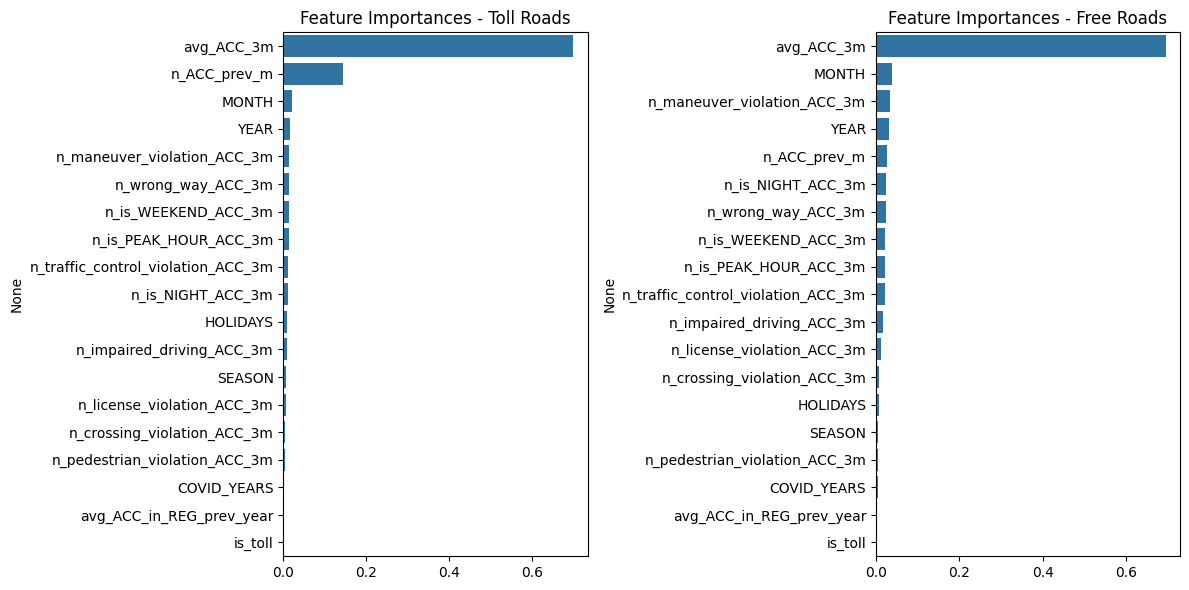

In [ ]:
# Feature importances
importances_toll = pd.Series(rf_toll.feature_importances_, index=X_toll.columns).sort_values(ascending=False)
importances_free = pd.Series(rf_free.feature_importances_, index=X_free.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=importances_toll.values, y=importances_toll.index)
plt.title("Feature Importances - Toll Roads")

plt.subplot(1, 2, 2)
sns.barplot(x=importances_free.values, y=importances_free.index)
plt.title("Feature Importances - Free Roads")

plt.tight_layout()
plt.show()

### Выводы: 

Гипотеза 1.1 опровергается: частота аварий на платных дорогах выще, чем на бесплатных. 

Гипотеза 1.2 подтверждается.

---

# Hot Spots

In [ ]:
acc_hot_spots = pd.read_csv("C:/Users/Настя/YandexDisk-n4skolesnikova/HSE 4th year/Graduation Thesis/data/ACCIDENTS_HOT_SPOTS.csv")
acc_hot_spots = acc_hot_spots.drop('Unnamed: 0', axis=1)
print(acc_hot_spots.shape)
acc_hot_spots.head()

(440127, 4)


,REGION,road_name,is_HOT_SPOT,CLUSTER
0,3,М-4 Дон Москва - Воронеж - Ростов-на-Дону - Кр...,0,-1
1,3,М-4 Дон Москва - Воронеж - Ростов-на-Дону - Кр...,0,-1
2,3,Р-217 Кавказ автомобильная дорога М-4 Дон - Вл...,0,-1
3,3,М-4 Дон Москва - Воронеж - Ростов-на-Дону - Кр...,0,-1
4,3,Р-217 Кавказ автомобильная дорога М-4 Дон - Вл...,0,-1


In [ ]:
le = LabelEncoder()
acc_hot_spots['road_name_encoded'] = le.fit_transform(acc_hot_spots['road_name'])
acc_hot_spots['region_road'] = acc_hot_spots['REGION'].astype(str) + '_' + acc_hot_spots['road_name_encoded'].astype(str)

hotspot_share = (
    acc_hot_spots
    .groupby('region_road')['is_HOT_SPOT']
    .mean()
    .reset_index(name='HOTSPOT_share')
)

df_hot = df.merge(hotspot_share, on='region_road', how='left')

In [ ]:
df_hot.columns

Index(['REGION', 'region_road', 'YEAR_MONTH', 'n_ACCIDENTS', 'MONTH', 'SEASON',
       'YEAR', 'COVID_YEARS', 'HOLIDAYS', 'avg_ACC_in_REG_prev_year',
       'avg_ACC_3m', 'n_ACC_prev_m', 'n_wrong_way_ACC_3m',
       'n_pedestrian_violation_ACC_3m', 'n_impaired_driving_ACC_3m',
       'n_maneuver_violation_ACC_3m', 'n_traffic_control_violation_ACC_3m',
       'n_license_violation_ACC_3m', 'n_crossing_violation_ACC_3m',
       'n_is_WEEKEND_ACC_3m', 'n_is_NIGHT_ACC_3m', 'n_is_PEAK_HOUR_ACC_3m',
       'is_toll', 'HOTSPOT_share'],
      dtype='object')

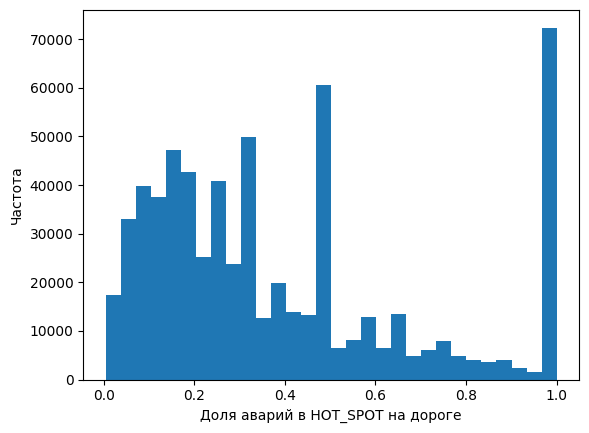

In [ ]:
nonzero = df_hot[df_hot['HOTSPOT_share'] > 0]['HOTSPOT_share']

plt.hist(nonzero, bins=30)
plt.xlabel('Доля аварий в HOT_SPOT на дороге')
plt.ylabel('Частота')
plt.show()

In [ ]:
q75_nz = nonzero.quantile(0.75)
print("75-й квантиль ненулевых долей:", q75_nz)

df_hot['is_HOTSPOT'] = (df_hot['HOTSPOT_share'] > q75_nz).astype(int)

df_hot = df_hot[df_hot['is_HOTSPOT'] == 1]
df_hot = df_hot.drop(columns='HOTSPOT_share', axis=1)

75-й квантиль ненулевых долей: 0.5035460992907801


## Econometrics

In [ ]:
toll_roads_percent = ((df_hot['is_toll'] == 1).sum() / df_hot.shape[0]) * 100
print(f"Percent of obs on toll roads (with negative sampling): {round(toll_roads_percent, 2)}%\n")

df_accidents = df_hot[df_hot['n_ACCIDENTS'] > 0]
toll_accidents_percent = ((df_accidents['is_toll'] == 1).sum() / df_accidents.shape[0]) * 100
print(f"Percent of accidents on toll roads (without negative sampling): {round(toll_accidents_percent, 2)}%")

Percent of obs on toll roads (with negative sampling): 0.98%

Percent of accidents on toll roads (without negative sampling): 3.01%


----

### PooledOLS

In [ ]:
df_weighted = df_hot.copy()

df_weighted['YEAR_MONTH'] = pd.to_datetime(df_weighted['YEAR_MONTH'])
df_weighted = df_weighted.set_index(['region_road', 'YEAR_MONTH'])

# weights = df_weighted["is_toll"].apply(lambda x: 3.0 if x == 1 else 1.0)

In [ ]:
p_toll = df_weighted['is_toll'].mean()
p_free = 1 - p_toll

# Тогда классический inverse-frequency weighting:
#   вес для toll = p_free / p_toll
#   вес для free = 1
w_toll = p_free / p_toll
print(f"p_toll = {p_toll:.4f}, so w_toll ≈ {w_toll:.1f}")

# Применяем
weights = df_weighted['is_toll'].apply(lambda x: w_toll if x == 1 else 1.0)

p_toll = 0.0098, so w_toll ≈ 101.4


In [ ]:
meaningful_df = df_weighted.drop(['REGION', 'n_ACCIDENTS'], axis=1)
meaningful_df = meaningful_df.select_dtypes(include=['int64', 'float64'])
cols = meaningful_df.columns.to_list()

In [ ]:
X = sm.add_constant(df_weighted[cols])

y = df_weighted['n_ACCIDENTS']

model = PooledOLS(y, X, weights=weights)
res = model.fit(cov_type='robust')

print('\n3. Full model (sample weights):')
print(res.summary)


3. Full model (sample weights):
                          PooledOLS Estimation Summary                          
Dep. Variable:            n_ACCIDENTS   R-squared:                        0.8642
Estimator:                  PooledOLS   R-squared (Between):              0.9979
No. Observations:              159063   R-squared (Within):               0.2726
Date:                Thu, May 08 2025   R-squared (Overall):              0.8642
Time:                        02:04:23   Log-likelihood                -3.647e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                   6.791e+04
Entities:                        1433   P-value                           0.0000
Avg Obs:                       111.00   Distribution:               F(19,159043)
Min Obs:                       111.00                                           
Max Obs:                       111.00   F-statistic (robust):             17

### Negative Binomial Regression

In [ ]:
mean = df_hot['n_ACCIDENTS'].mean()
var = df_hot['n_ACCIDENTS'].var()
print(f'Mean: {mean:.3f}, Variance: {var:.3f}, Ratio: {var / mean:.2f}')

Mean: 0.586, Variance: 5.452, Ratio: 9.31


In [ ]:
base = 'n_ACCIDENTS ~ is_toll + '

model_nb = smf.glm(
    formula=base + ' + '.join(cols),
    data=df_weighted,
    family=sm.families.NegativeBinomial(),
    freq_weights = weights
).fit(cov_type='HC3')

print(model_nb.summary())

c:\Users\Настя\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:            n_ACCIDENTS   No. Observations:               159063
Model:                            GLM   Df Residuals:                   314998
Model Family:        NegativeBinomial   Df Model:                           19
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.1519e+05
Date:                Thu, 08 May 2025   Deviance:                   2.7305e+05
Time:                        02:06:57   Pearson chi2:                 3.78e+05
No. Iterations:                    29   Pseudo R-squ. (CS):             0.9607
Covariance Type:                  HC3                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

### RE model

In [ ]:
base = 'n_ACCIDENTS ~ is_toll + '

mod_re = RandomEffects.from_formula(
    base + ' + '.join(cols),
    data=df_weighted,
    weights=weights
)

res_re = mod_re.fit(cov_type='robust')
print(res_re.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:            n_ACCIDENTS   R-squared:                        0.8832
Estimator:              RandomEffects   R-squared (Between):              0.9982
No. Observations:              159063   R-squared (Within):               0.2723
Date:                Thu, May 08 2025   R-squared (Overall):              0.8832
Time:                        02:07:50   Log-likelihood                -3.647e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                    6.33e+04
Entities:                        1433   P-value                           0.0000
Avg Obs:                       111.00   Distribution:               F(19,159044)
Min Obs:                       111.00                                           
Max Obs:                       111.00   F-statistic (robust):             2394.7
                            

### Machine Learning

In [ ]:
df_hot = df_hot.drop(['REGION'], axis=1)

df_toll = df_hot[df_hot['is_toll'] == 1]
df_free = df_hot[df_hot['is_toll'] == 0]

In [ ]:
meaningful_df = df_hot.drop(['n_ACCIDENTS'], axis=1)
meaningful_df = meaningful_df.select_dtypes(include=['int64', 'float64'])
features = meaningful_df.columns.to_list()

X_toll = df_toll[features]
y_toll = df_toll['n_ACCIDENTS']
X_train_toll, X_test_toll, y_train_toll, y_test_toll = train_test_split(X_toll, y_toll, test_size=0.2, random_state=42)

X_free = df_free[features]
y_free = df_free['n_ACCIDENTS']
X_train_free, X_test_free, y_train_free, y_test_free = train_test_split(X_free, y_free, test_size=0.2, random_state=42)

rf_toll = RandomForestRegressor(random_state=42)
rf_toll.fit(X_train_toll, y_train_toll)

rf_free = RandomForestRegressor(random_state=42)
rf_free.fit(X_train_free, y_train_free)

RandomForestRegressor(random_state=42)

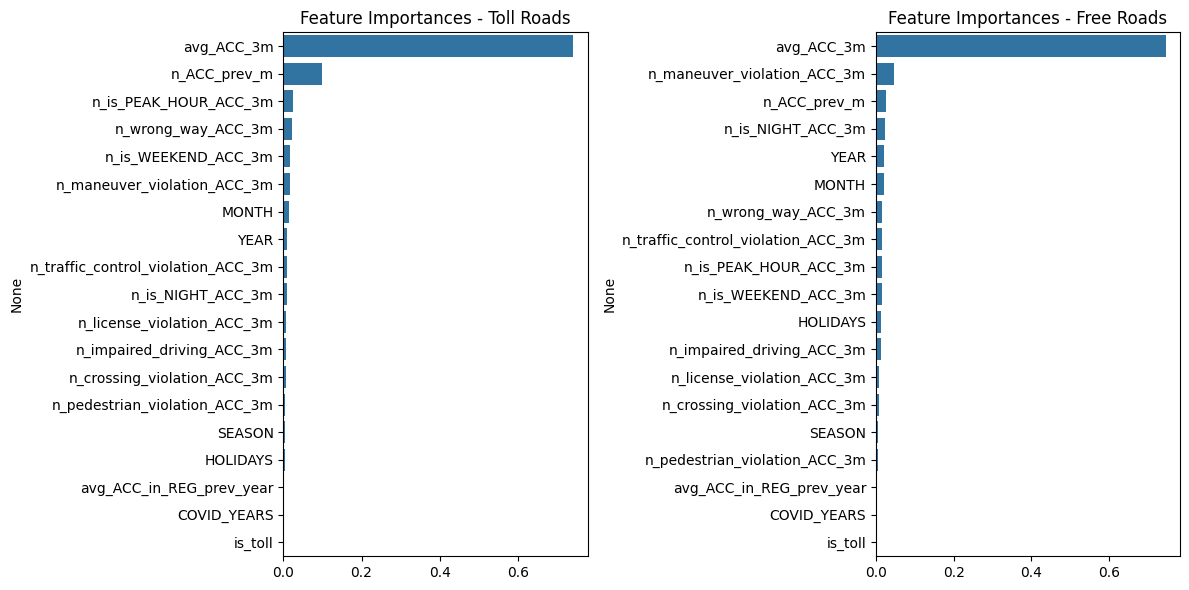

In [ ]:
# Feature importances
importances_toll = pd.Series(rf_toll.feature_importances_, index=X_toll.columns).sort_values(ascending=False)
importances_free = pd.Series(rf_free.feature_importances_, index=X_free.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=importances_toll.values, y=importances_toll.index)
plt.title("Feature Importances - Toll Roads")

plt.subplot(1, 2, 2)
sns.barplot(x=importances_free.values, y=importances_free.index)
plt.title("Feature Importances - Free Roads")

plt.tight_layout()
plt.show()